In [2]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

In [3]:
from typing import TypedDict, List, Dict, Optional, Union, Literal
from pydantic import BaseModel


In [35]:
class SupervisorState(BaseModel):
    trigger_action: str

In [36]:
class SectionConfig(BaseModel):
    section_name: str
    description: str
    

class UserState(BaseModel):
    main_topic: str
    sections: List[SectionConfig]
    constraints: str
    dynamic_generation: bool
    context: str   

In [37]:
class GeneratedConfig(BaseModel):
    section_name: str
    content: str

class GeneratedState(BaseModel):
    generated_content : List[GeneratedConfig]
    
    

In [38]:
class SemanticChangeConfig(BaseModel):
    section_name: str
    issue: str
    suggestion: str

class StructuralChangeConfig(BaseModel):
    action: Literal["add", "remove", "rename", "reorder"]
    section_name: str
    context: str

class EvaluatorState(BaseModel):
    coherency_score: float

    # Problems with wording, clarity, logic, tone, alignment
    semantic_issues: Union[
        Literal["None"],
        List[SemanticChangeConfig]
    ]

    # High-level structural changes: add/remove/reorder sections
    structural_changes: Union[
        Literal["None"],
        List[StructuralChangeConfig]
    ]

    # Helps supervisor pick refine path
    next_action: Literal[
        "semantic_refine",
        "structural_refine",
        "no_action"
    ]

    # Brief evaluator thoughts (allowed ALWAYS)
    evaluator_diagnostic_summary: str


    
    

In [39]:
from langchain_core.prompts import ChatPromptTemplate

full_gen_prompt = ChatPromptTemplate.from_template("""
You are an expert content generation model. Your job is to generate high-quality, coherent text for each given section of a document based on the user configuration.

Below is the information provided by the user. Use ALL of it carefully.

=========================
        USER CONFIG
=========================

{USER_CONFIG}

=========================
       INSTRUCTIONS
=========================

1. Generate **clear, structured, coherent text** for each section.
2. Each section must have a final output in this format:
   - "name": <section name>
   - "text": <generated text>
3. Respect ALL constraints strictly (tone, style, transformation rules, etc.).
4. Only generate content for the sections. Do NOT invent extra topics.
5. Ensure continuity and coherence across all sections.
6. Use mordern markdown format if needed.
7. Your final output MUST be valid JSON in this structure:
  
{{
  "generated_content": [
    {{ "section_name": "...", "content": "..." }},
  ]
}}

Return parseable JSON only, with no commentary.
""")


evaluator_prompt = ChatPromptTemplate.from_template("""
Your role is to act as a strict, high-signal evaluator of the generated document.  
You must determine whether the content is acceptable as-is, or if it requires:
1. Semantic refinements  
2. Structural modifications  
3. No changes  

Your evaluation determines which refinement node the system executes next.

ONLY report issues that meaningfully affect understanding, correctness, coherence, structure, or alignment with user constraints.  
Ignore trivial or cosmetic matters.

========================================================
                 USER OBJECTIVES
========================================================

{USER_CONFIG}

ALLOW_DYNAMIC_CONTENT_GENERATION = {ALLOW_DYNAMIC_CONTENT_GENERATION}

========================================================
           GENERATED CONTENT TO EVALUATE
========================================================
{GENERATED_CONTENT}

========================================================
           EVALUATION INSTRUCTIONS
========================================================

You will evaluate the content on TWO independent axes:
semantic quality and structural quality.

--------------------------------------------------------
1. SEMANTIC QUALITY (Meaning, clarity, correctness)
--------------------------------------------------------
Identify semantic issues ONLY if they meaningfully harm:

- clarity or understanding  
- coherence or logical flow  
- correctness or internal consistency  
- alignment with topic  
- adherence to constraints in a non-trivial way  

For each semantic issue:
Return a SemanticChangeConfig object:
- section_name  
- issue  
- suggestion (clear, actionable, non-trivial improvement)

If there are NO meaningful semantic issues, return "None".

--------------------------------------------------------
2. STRUCTURAL QUALITY (Sections, ordering, presence)
--------------------------------------------------------
Evaluate whether the structure is logically sound AND aligned with the intended outline.

You must evaluate structure differently depending on ALLOW_DYNAMIC_CONTENT_GENERATION:

--------------------------------------------------------
A. RIGID MODE (ALLOW_DYNAMIC_CONTENT_GENERATION = "false")
--------------------------------------------------------
- You MUST NOT propose structural actions (add/remove/reorder/rename).
- You MUST NOT propose creative section names or re-frame the outline.
- You MAY diagnose structural issues, but ONLY inside evaluator_diagnostic_summary.
- The model in refinement steps MUST strictly follow the user's provided section list.
- structural_changes MUST be "None".

This mode is for users who want *strict adherence* to the provided structure.

--------------------------------------------------------
B. FLEXIBLE MODE (ALLOW_DYNAMIC_CONTENT_GENERATION = "true")
--------------------------------------------------------
The evaluator is permitted to make **controlled creative suggestions** IF they help clarity, structure, or alignment with constraints.

Allowed creativity:
- Propose new sections when meaningfully valuable  
- Suggest renaming sections for stronger clarity or alignment  
- Suggest reordering for better narrative flow  
- Suggest merging or splitting sections  
- Suggest more expressive or more natural hierarchical organization  

BUT all creativity must obey:
1. Do NOT contradict user constraints  
2. Do NOT violate topic, tone, or mandatory elements  
3. Do NOT overwrite user-intended meaning  
4. Creativity must be purposeful, not decorative  

This mode is for users who want guided, intelligent expansion.

If no structural modifications are required, return "None".

--------------------------------------------------------
3. DECIDE next_action
--------------------------------------------------------

Return exactly ONE of:

- "structural_refine"  
      → if structural_changes list is NOT "None"

- "semantic_refine"  
      → if structural_changes = "None" AND semantic_issues list is NOT "None"

- "no_action"  
      → if BOTH semantic_issues and structural_changes are "None"

--------------------------------------------------------
4. EVALUATOR DIAGNOSTIC SUMMARY (User-facing only)
--------------------------------------------------------
Provide a 2–4 sentence expert summary of:
- overall quality  
- useful high-level insights  
- potential conceptual improvements  
- structural opportunities (even in rigid mode)  

This field is **ALWAYS allowed**, regardless of dynamic mode.

IMPORTANT:
- This summary is for the USER, not for the system.
- It must NOT influence routing logic (that is handled by next_action).
- Do NOT include actionable suggestions here — only insights.

--------------------------------------------------------
5. COHERENCY SCORE
--------------------------------------------------------
Provide a coherency score (0–1) based on:
- overall logical clarity  
- organization  
- semantic cohesion  
- conceptual soundness  

This score is INDEPENDENT of refinement rules or dynamic mode.

========================================================
              OUTPUT JSON FORMAT (STRICT)
========================================================

Return ONLY a JSON object matching EXACTLY this schema:

{{
  {{"coherency_score": <float 0–1>,}}
  {{"overall_pass": <true/false>,}}

  {{"semantic_issues": "None" OR [
     {{
       "section_name": "...",
       "issue": "...",
       "suggestion": "..."
     }}
  ],}}

  {{"structural_changes": "None" OR [
     {{
       "action": "add" | "remove" | "rename" | "reorder",
       "section_name": "...",
       "context": "..."
     }}
  ],}}

  {{"next_action": "semantic_refine" | "structural_refine" | "no_action",}}

  {{"evaluator_diagnostic_summary": "..."}}
}}

Return parseable JSON only, with no commentary.
""")



semantic_refine_prompt = ChatPromptTemplate.from_template("""
You are an expert rewriting and refinement model. Your job is to improve the already generated document sections **only where required**, based on evaluator feedback.

=========================
        USER CONFIG
=========================

{USER_CONFIG}

=========================
    ORIGINAL GENERATED CONTENT
=========================
{GENERATED_CONTENT}

=========================
     SEMANTIC FEEDBACK
=========================

{SEMANTIC_FEEDBACK}

=========================
        INSTRUCTIONS
=========================

1. **Refine ONLY the sections the evaluator marked as problematic.**
2. When refining:
   - Fix coherence issues
   - Follow evaluator's suggestions precisely
   - Follow all original constraints (tone, style, length rules)
3. Preserve the section names. Only update the text.
4. For sections with *no issues*, return the existing text unchanged.
5. Use mordern markdown format if needed.
6. You MUST output valid JSON in the following exact format:

{{
  "generated_content": [
    {{ "section_name": "...", "content": "..." }},
  ]
}}

Return parseable JSON only, with no commentary.
""")


structural_refine_prompt = ChatPromptTemplate.from_template("""
You are a structural refinement model. Your job is to update the
document’s SECTION OUTLINE and CONTENT according to evaluator
structural feedback.

You MUST follow the evaluator’s structural_changes exactly.

=========================
        USER CONFIG
=========================

{USER_CONFIG}

=========================
     ORIGINAL CONTENT
=========================
{GENERATED_CONTENT}

=========================
   STRUCTURAL FEEDBACK
=========================
{STRUCTURAL_FEEDBACK}

=========================
        INSTRUCTIONS
=========================

Your tasks:

1. Apply each structural change in order:
   - Add new section(s) (generate content following constraints)
   - Remove sections
   - Rename sections
   - Reorder sections

2. After structural operations, regenerate ONLY what changed.
   Unchanged sections must stay exactly the same.

3. Follow all original constraints (tone, length, style).

4. Use mordern markdown format if needed.

Return JSON in the following exact format:

{{
  "generated_content": [
     {{ "section_name": "...", "content": "..." }},
     {{ "section_name": "...", "content": "..." }}
  ]
}}

Return parseable JSON only, with no commentary.
""")


In [50]:
## HELPER FUNCS

def format_user_config(usr_inp):
    lines =[]
    lines.append(f"\n## Main Topic: {usr_inp['main_topic']}.")
    lines.append("## User Defined Sample Sections: ")
    sections = usr_inp["sections"]
    for i,sec in enumerate(sections, start = 1 ):
        lines.append(f"{i}. {sec['section_name']} : \n - {sec['description']}")
    if usr_inp.get('expected_sections_count'):
        lines.append(f"## Number of Sections User Expects: {usr_inp['expected_sections_count']}")
    lines.append(f"## User defined CONSTRAINTS: {usr_inp['constraints']}")
    lines.append(f"## Additional User Context: {usr_inp['context']}")

    return "\n\n".join(lines)
def format_sections(sections):
    lines =[]
    for i,sec in enumerate(sections, start = 1 ):
        lines.append(f"{i}. {sec["section_name"]} -> {sec["description"]}")

    return "\n".join(lines)

def format_generated_content(content):
    lines =[]
    for i,sec in enumerate(content, start = 1 ):
        lines.append(f"{i}. {sec["section_name"]} : \n - {sec["content"]}")

    return "\n\n".join(lines)

def format_evaluation(evaluator_state):

    lines = []
    lines.append(f"### Evaluation Result ###")
    lines.append(f"- Overall Coherency Score: {evaluator_state['coherency_score']}")

    # 1. STRUCTURAL CHANGES (Highest Priority)
    structural = evaluator_state["structural_changes"]
    if isinstance(structural, list) and len(structural) > 0:
        lines.append("\n## Structural Changes Required ##\n")
        for i, change in enumerate(structural, start=1):
            lines.append(
                f"{i}. Action: **{change['action']}**\n"
                f"   - Section: {change['section_name']}\n"
                f"   - Context: {change['context']}"
            )
        return "\n".join(lines)
    else:
        lines.append("\n- No structural issues.")

    # 2. SEMANTIC ISSUES (Only if no structural)
    semantic = evaluator_state["semantic_issues"]
    if isinstance(semantic, list) and len(semantic) > 0:
        lines.append("\n## Semantic Refinements Required ##\n")
        for i, issue in enumerate(semantic, start=1):
            lines.append(
                f"{i}. Section: **{issue['section_name']}**\n"
                f"   - Issue: {issue['issue']}\n"
                f"   - Suggestion: {issue['suggestion']}"
            )
    else:
        lines.append("\n- No semantic issues.")


    # If neither structural nor semantic — next_action = no_action
    return "\n".join(lines)



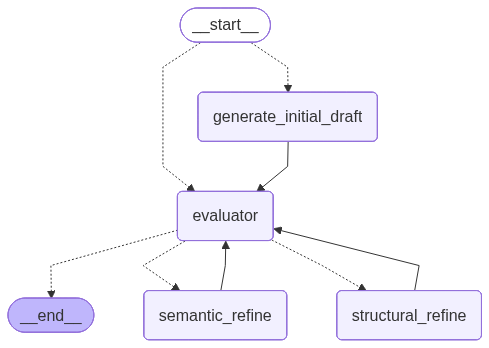

In [51]:
from IPython.display import Image
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END, START
import json

  
class GraphState(TypedDict):
    # ===== USER STATE =======
    supervisor_state: SupervisorState
    user_state: UserState
    generated_state: GeneratedState
    evaluator_state: EvaluatorState
    iteration: int
    evaluator_history: List[dict] = []
    
    

# Create nodes (functions)
def generate_initial_draft(state: GraphState) -> GraphState:
    print("\n" + "="*60)
    print("---GENERATE INITIAL DRAFT NODE---")
    print("="*60 + "\n")
    
    llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    response_schema=GeneratedState.model_json_schema(),  
    response_mime_type = 'application/json',
)
    # Extract user state
    user_state = state["user_state"]
    
    # Format the user fields as required
    formatted_user_config = format_user_config(user_state)

    # Prepare the input for the prompt
    prompt_load = {
        "USER_CONFIG": formatted_user_config,
    }

    # Format the prompt using the template
    prompt = full_gen_prompt.format(**prompt_load)
    
    # Invoke the LLM with the formatted prompt
    response = llm.invoke(prompt)
    
    # Assuming the response is what you want
    return {"generated_state":json.loads(response.content)}


def evaluator(state: GraphState) -> GraphState:
    """ Evaluates the generated content """
    print("\n" + "="*60)
    print("---EVALUATOR NODE---")
    print("="*60 + "\n")
          
    llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.3,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    response_schema=EvaluatorState.model_json_schema(),  
    response_mime_type = 'application/json',
)
    user_state = state["user_state"]
    generated_state = state["generated_state"]

    # Format the user fields as required
    formatted_user_config = format_user_config(user_state)
    # Format the generated content as required
    formatted_generated_content = format_generated_content(generated_state["generated_content"])

    # Prepare the input for the prompt
    prompt_load = {
        "USER_CONFIG": formatted_user_config,
        "ALLOW_DYNAMIC_CONTENT_GENERATION": user_state["dynamic_generation"],
        "GENERATED_CONTENT": formatted_generated_content,
    }

    # Format the prompt using the template
    prompt = evaluator_prompt.format(**prompt_load)

    # Invoke the LLM with the formatted prompt
    response = llm.invoke(prompt)
    eval_data = json.loads(response.content)


    # ---------- PRETTY PRINT SUMMARY ----------
    print("🔍 Evaluation Summary")
    print("-" * 60)
    print(format_evaluation(eval_data))
    print()
    # -----------------------------------------

    # store evaluator output for this step
    state["evaluator_state"] = eval_data

    if "evaluator_history" not in state:
        state["evaluator_history"] = []
    # append memory
    state["evaluator_history"].append({
        "coherency_score": eval_data["coherency_score"],
        "next_action": eval_data["next_action"],
        "diagnostic_summary": eval_data["evaluator_diagnostic_summary"],
        "semantic_issues": eval_data["semantic_issues"],
        "structural_changes": eval_data["structural_changes"],
        "evaluator_diagnostic_summary": eval_data["evaluator_diagnostic_summary"],
    })

    return state


    
def should_refine_edge(state: GraphState) -> GraphState:
    """ Decides if generated content needs refinement """
    evaluated_state = state["evaluator_state"]
    next_action = evaluated_state["next_action"]
    if next_action != "no_action":
        return next_action
    return END
    


def semantic_refine(state:GraphState) -> GraphState:
    """ Semantic refinement of sections """
    print("\n" + "="*60)
    print("---SEMANTIC REFINEMENT NODE---")
    print("="*60 + "\n")

    llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    response_schema=GeneratedState.model_json_schema(),  
    response_mime_type = 'application/json',
)
    user_state = state["user_state"]
    generated_state = state["generated_state"]
    evaluator_state = state["evaluator_state"]

    # Format the user fields as required
    formatted_user_config = format_user_config(user_state)
    # Format the generated content as required
    formatted_generated_content = format_generated_content(generated_state["generated_content"])
    # Format the evaluator content as required
    formatted_evaluation = format_evaluation(evaluator_state)


    # Prepare the input for the prompt
    prompt_load = {
        "USER_CONFIG": formatted_user_config,
        "GENERATED_CONTENT": formatted_generated_content,
        "SEMANTIC_FEEDBACK": formatted_evaluation,
    }

    # Format the prompt using the template
    prompt = semantic_refine_prompt.format(**prompt_load)

    # Invoke the LLM with the formatted prompt
    response = llm.invoke(prompt)
    
    return {"generated_state":json.loads(response.content)}

def structural_refine(state:GraphState) -> GraphState:
    """ Structural refinement of sections """
    print("\n" + "="*60)
    print("---STRUCTURAL REFINEMENT NODE---")
    print("="*60 + "\n")

    llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    response_schema=GeneratedState.model_json_schema(),  
    response_mime_type = 'application/json',
)
    user_state = state["user_state"]
    generated_state = state["generated_state"]
    evaluator_state = state["evaluator_state"]

    # Format the user fields as required
    formatted_user_config = format_user_config(user_state)
    # Format the generated content as required
    formatted_generated_content = format_generated_content(generated_state["generated_content"])
    # Format the evaluator content as required
    formatted_evaluation = format_evaluation(evaluator_state)


    # Prepare the input for the prompt
    prompt_load = {
        "USER_CONFIG": formatted_user_config,
        "GENERATED_CONTENT": formatted_generated_content,
        "STRUCTURAL_FEEDBACK": formatted_evaluation,
    }

    # Format the prompt using the template
    prompt = structural_refine_prompt.format(**prompt_load)

    # Invoke the LLM with the formatted prompt
    response = llm.invoke(prompt)
    
    return {"generated_state":json.loads(response.content)}

    
def supervisor(state:GraphState) -> GraphState:
    supervisor_state = state["supervisor_state"]
    if supervisor_state["trigger_action"] == "generate":
        return "generate_initial_draft"
    elif supervisor_state["trigger_action"] == "evaluate":
        return "evaluator"
    # return "generate_initial_draft"

# Create the graph
graph = StateGraph(GraphState)

# Add nodes
graph.add_conditional_edges(
    START,
    supervisor, 
    ["generate_initial_draft", "evaluator"]
)
graph.add_node("generate_initial_draft", generate_initial_draft)
graph.add_node("evaluator",evaluator)
graph.add_node("semantic_refine", semantic_refine)
graph.add_node("structural_refine",structural_refine)

# Set entry point and edges
# graph.set_entry_point("generate_initial_draft")
graph.add_edge("generate_initial_draft", "evaluator")
graph.add_edge("evaluator",END)
graph.add_conditional_edges(
    "evaluator",
    should_refine_edge,
    ["semantic_refine", "structural_refine", END]
)
graph.add_edge("semantic_refine", "evaluator")
graph.add_edge("structural_refine", "evaluator")


# Compile the graph
chain = graph.compile()
Image(chain.get_graph().draw_mermaid_png())

In [ ]:
## IDEAL CASE

# test = {
#     "user_state": {
#   "main_topic": "Introduction to Microservices Architecture",
# "dynamic_generation":"true",
#   "sections": [
#     {
#       "section_name": "Overview of Microservices",
#       "description": "Explain what microservices are, including the definition and the rationale behind breaking monolithic systems into smaller components."
#     },
#     {
#       "section_name": "Benefits of Microservices",
#       "description": "Describe advantages such as scalability, independent deployment, and team autonomy."
#     },
#     {
#       "section_name": "Challenges of Microservices",
#       "description": "Discuss the difficulties teams face, including distributed complexity, monitoring, and operational overhead."
#     },
#     {
#       "section_name": "Best Practices",
#       "description": "Provide actionable recommendations for building and maintaining microservice-based systems."
#     }
#   ],

#   "constraints": "Tone: professional but friendly. Length: 120–180 words per section. Style: explanatory, clear, and beginner-friendly. Do not use overly technical jargon unless necessary.",

#   "context": "Assume the reader is a junior software developer learning microservices for the first time. The Reader enjoys to read in form of points and subpoints than paragraph, stick to covering main points/subpoints"
#     }
# }

## GENERIC ROUGH CASE
test =  {
  "supervisor_state": { "trigger_action": "generate"},
  "user_state": {
    "main_topic": "Something about climate change impacts",
    "dynamic_generation": "true",
    "expected_sections_count":"5",
    "sections": [
      {
        "section_name": "effects on weather??",
        "description": "write like how weather gets messed up because of climate change. Maybe include storms and floods? also maybe put pollution (not sure if thats related but just add it somewhere)"
      },
      {
        "section_name": "Intro",
        "description": "just talk about climate change a bit ig, i want it like not too long bc its boring but my professor said it should be kind of detailed so idk"
      },
      {
        "section_name": "idk maybe solutions",
        "description": "just mention what we can do to stop it but dont go too deep i think. professor said make it practical and also academic?? confusing"
      }
    ],

    "constraints": "This is for my college assignment and i need like a clean structure but i dont know the structure. maybe 600-800 words total??? i hate reading big paragraphs so dont make it too blocky. don't make it sound like a wikipedia page, would appreciate points. also try to make it like highly chill like a ppt but the teacher is pretty chill!",

    "context": "I have literally no idea how climate change works so assume im a beginner. This assignment is due tomorrow so please make it look like i know what im talking about a bit. You can also add sections if needed because i dont know what all should be included."
  }
}


In [53]:
print(format_user_config(test["user_state"]))


## Main Topic: Something about climate change impacts.

## User Defined Sample Sections: 

1. effects on weather?? : 
 - write like how weather gets messed up because of climate change. Maybe include storms and floods? also maybe put pollution (not sure if thats related but just add it somewhere)

2. Intro : 
 - just talk about climate change a bit ig, i want it like not too long bc its boring but my professor said it should be kind of detailed so idk

3. idk maybe solutions : 
 - just mention what we can do to stop it but dont go too deep i think. professor said make it practical and also academic?? confusing

## Number of Sections User Expects: 5

## User defined CONSTRAINTS: This is for my college assignment and i need like a clean structure but i dont know the structure. maybe 600-800 words total??? i hate reading big paragraphs so dont make it too blocky. don't make it sound like a wikipedia page, would appreciate points. also try to make it like highly chill like a ppt but the t

In [54]:
# Execute the graph
result = chain.invoke(test)
# print(result["response"])

KeyError: 'supervisor_state'

In [55]:
result["generated_state"]

{'generated_content': [{'section_name': 'Introduction to Climate Change',
   'content': "Climate change refers to significant, long-term shifts in Earth's global weather patterns. This phenomenon represents a fundamental alteration to our planet's climate system, extending beyond typical natural variations. It involves widespread changes in global temperatures, precipitation patterns, and the frequency of extreme weather events. The primary driver behind these changes is human activity, particularly the emission of greenhouse gases from industrial processes, energy consumption, and land-use changes. Understanding climate change is crucial as its impacts are already evident across various ecosystems and human societies, necessitating urgent attention and action.\n\nKey aspects of climate change include:\n*   **Global Scale:** Impacts are observed worldwide, affecting every continent and ocean.\n*   **Long-Term Trend:** It represents a sustained shift, not just short-term weather fluctua

In [56]:
test2 = {
  "supervisor_state": { "trigger_action": "evaluate"},
  "user_state": {
    "main_topic": "Something about climate change impacts",
    "dynamic_generation": 'true',
    "sections": [
      {
        "section_name": "effects on weather??",
        "description": "write like how weather gets messed up because of climate change. Maybe include storms and floods? also maybe put pollution (not sure if thats related but just add it somewhere)"
      },
      {
        "section_name": "Intro",
        "description": "just talk about climate change a bit ig, i want it like not too long bc its boring but my professor said it should be kind of detailed so idk"
      },
      {
        "section_name": "idk maybe solutions",
        "description": "just mention what we can do to stop it but dont go too deep i think. professor said make it practical and also academic?? confusing"
      }
    ],

    "constraints": "This is for my college assignment and i need like a clean structure but i dont know the structure. short snippet lines. i hate reading big paragraphs so dont make it too blocky. don't make it sound like a wikipedia page, would appreciate points. also try to make it like highly chill like a ppt but the teacher is pretty chill!",

    "context": "I have literally no idea how climate change works so assume im a beginner. This assignment is due tomorrow so please make it look like i know what im talking about a bit. You can also add sections if needed because i dont know what all should be included."
  },

"generated_state" : {
  "generated_content": [
    {
      "section_name": "Fun Facts About Penguins",
      "content": "Penguins live in the Southern Hemisphere and are not directly related to climate change assignments. But they are sometimes used as symbols of melting ice caps. This section is not really needed but here it is."
    },
    {
      "section_name": "Conclusion",
      "content": "Before even getting into the details, here is a conclusion for no reason. Climate change is complicated, and people need to work together to fix it. This wraps things up even though nothing has been explained yet."
    },
    {
      "section_name": "Extreme Weather Events Are Kinda Wild",
      "content": "Storms get worse, heatwaves pop up, and floods happen more often. Also tornadoes sometimes but maybe not related? Anyway this section belongs somewhere but probably not here."
    },
    {
      "section_name": "Random Environmental Thoughts",
      "content": "Sometimes I think about recycling and how people don’t do it enough. Also solar panels are shiny. Not sure how much of this fits your user's assignment."
    },
    {
      "section_name": "Introduction to Climate Change",
      "content": "Climate change is a long-term shift in temperatures and weather patterns. This should probably be the first section but now it's buried in the middle. Human activities like burning fossil fuels release greenhouse gases."
    },
    {
      "section_name": "idk maybe a Section About Volcanoes?",
      "content": "Volcanoes release gases and ash. Not super relevant to human-caused climate change but people sometimes confuse them. So here's a whole section that your evaluator should probably flag."
    },
    {
      "section_name": "Beyond Weather: Impacts That Aren't Weather",
      "content": "Sea levels rise, oceans acidify, biodiversity decreases. This section is relevant but it’s in the wrong spot and also slightly renamed to confuse structure."
    },
    {
      "section_name": "Solutions (Maybe?)",
      "content": "* Switch to renewable energy somehow\n* Better agriculture stuff\n* Insulate houses?? (not sure but sounds right)\nThis section is semi-relevant but messy."
    },
    {
      "section_name": "The Science Behind It",
      "content": "CO2 traps heat and a greenhouse effect intensifies. This actually belongs earlier in the structure but is pushed towards the end."
    },
    {
      "section_name": "Completely Useless Section",
      "content": "This section has absolutely no purpose. Climate change is real but this part is filler text for testing the evaluator logic."
    }
  ]
}
}


result2 = chain.invoke(test2)


---EVALUATOR NODE---

🔍 Evaluation Summary
------------------------------------------------------------
### Evaluation Result ###
- Overall Coherency Score: 0.1

## Structural Changes Required ##

1. Action: **remove**
   - Section: Fun Facts About Penguins
   - Context: This section is irrelevant and explicitly stated as not needed, violating topic alignment.
2. Action: **remove**
   - Section: Conclusion
   - Context: This section is a premature conclusion, appearing before any content has been explained, making it illogical.
3. Action: **remove**
   - Section: Random Environmental Thoughts
   - Context: This section contains irrelevant personal musings and explicitly states its irrelevance.
4. Action: **remove**
   - Section: idk maybe a Section About Volcanoes?
   - Context: This section is irrelevant to human-caused climate change and explicitly states it is not super relevant.
5. Action: **remove**
   - Section: Completely Useless Section
   - Context: This section explicitly st

In [60]:
# result2["generated_state"]["generated_content"]
result2["evaluator_history"]

[{'coherency_score': 0.1,
  'next_action': 'structural_refine',
  'diagnostic_summary': "The generated content is highly disorganized and contains numerous irrelevant and self-contradictory sections, making it unsuitable for a college assignment. It fails to meet the user's basic requirements for structure, clarity, and academic tone. Significant structural reorganization, including the removal of extraneous content and logical reordering of relevant sections, is critically needed. Additionally, the remaining content requires substantial semantic refinement to improve clarity, tone, and adherence to user constraints like using 'short snippet lines' and 'points'.",
  'semantic_issues': [{'section_name': 'Fun Facts About Penguins',
    'issue': "This section is completely irrelevant to the assignment's main topic and explicitly states it is not needed, violating topic alignment and user constraints.",
    'suggestion': "Remove this section entirely as it adds no value and detracts from t

In [45]:
from markdownify import markdownify as md
import html2text
from rich.console import Console
from rich.markdown import Markdown

h = html2text.HTML2Text()

console = Console()
# md_text = md(result["generated_state"]["generated_content"][5]["content"])
md_text = h.handle(result["generated_state"]["generated_content"][5]["content"])
console.print(Markdown(md_text))
# md_text


In summary, climate change represents a profound and urgent global challenge driven primarily by human-induced     
greenhouse gas emissions. We've explored its fundamental causes, from the enhanced greenhouse effect to the burning
of fossil fuels, and examined its far-reaching consequences. These impacts manifest not only as more frequent and  
intense extreme weather events but also as rising sea levels, significant biodiversity loss, ocean acidification,  
and threats to human health. Addressing this complex issue requires a comprehensive and integrated approach. By    
implementing both mitigation strategies—such as transitioning to renewable energy and improving energy             
efficiency—and adaptation measures—like building resilient infrastructure and developing sustainable agricultural  
practices—we can work towards a more sustainable and secure future. While the scale of the challenge is immense,   
collective action and informed choices at all levels offer a pathway to mitigate the worst effects of climate      
change and adapt to the changes already underway. Understanding these dynamics is the first step toward effective  
engagement and meaningful change.

In [27]:
### TESTING OUT STRUCTURED OUTPUT

from pydantic import BaseModel, Field
from typing import Literal
from langchain_google_genai import ChatGoogleGenerativeAI

class ProductReview(BaseModel):
    rating: int | None = Field(..., description="Rating from 1 to 5")
    sentiment: Literal["positive", "negative"]
    key_points: list[str]

agent = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite",
    temperature=0,
    response_schema=ProductReview.model_json_schema(),   # ✅ correct
    response_mime_type = 'application/json',
)

result = agent.invoke("Analyze this review: 'Great product, fast shipping, but expensive.'")
print(result)


content='{\n  "rating": null,\n  "sentiment": "positive",\n  "key_points": [\n    "Great product",\n    "fast shipping",\n    "expensive"\n  ]\n}' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'} id='lc_run--bcb4c927-690b-41d8-b796-f07e7aee440c-0' usage_metadata={'input_tokens': 15, 'output_tokens': 46, 'total_tokens': 61, 'input_token_details': {'cache_read': 0}}


In [28]:
result.content

'{\n  "rating": null,\n  "sentiment": "positive",\n  "key_points": [\n    "Great product",\n    "fast shipping",\n    "expensive"\n  ]\n}'

In [61]:
from dotenv import load_dotenv
import os

load_dotenv()

True